Evaluation Test: E2E

Common Task 1. Electron/photon classification

Submitted by Sarthak Rastogi (thesarthakrastogi@gmail.com)

To ML4SCI, CERN

#Importing and Examining data

In [1]:
import h5py
electron_data = h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
photon_data = h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')

In [2]:
electron_data.keys()

<KeysViewHDF5 ['X', 'y']>

In [3]:
electron_data['X']

<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4">

The key X seems to contain 249000 data samples, each a matrix of size 32 x 32, containing two channel values, hit energy and time.

In [4]:
electron_data['y']

<HDF5 dataset "y": shape (249000,), type "<f4">

The key y has the labels for these 249000 matrices.

In [5]:
input_elec = electron_data['X'][...]
label_elec = electron_data['y'][...]

In [6]:
input_phot = photon_data['X'][...]
label_phot = photon_data['y'][...]

Closing the files

In [7]:
electron_data.close()
photon_data.close()

#Combining the Electron and Photon data in unision to make our dataset.

In [8]:
import numpy as np
input_df = np.concatenate((input_elec, input_phot))
input_df.shape

(498000, 32, 32, 2)

In [9]:
label_df = np.concatenate((label_elec, label_phot))
label_df.shape

(498000,)

Our dataset is composed of 249,000 Electron samples followed by 249,000 Photon samples. It's important to shuffle the data, especially so that we don't get mini-batches of highly correlated data. This will help prevent bias.

However, since we're shuffling both the inputs and the labels, it's important to shuffle them in the same order.

In [10]:
import sklearn
input_df, label_df = sklearn.utils.shuffle(input_df, label_df)

#Splitting into train and test sets

In [11]:
split_horizontally_idx = int(input_df.shape[0]* 0.8)

input_df_train = input_df[:split_horizontally_idx , :]
print(input_df_train.shape)

input_df_test = input_df[split_horizontally_idx: , :]
print(input_df_test.shape)

(398400, 32, 32, 2)
(99600, 32, 32, 2)


In [12]:
split_horizontally_idx = int(label_df.shape[0]* 0.8)

label_df_train = label_df[:split_horizontally_idx]
print(label_df_train.shape)

label_df_test = label_df[split_horizontally_idx:]
print(label_df_test.shape)

(398400,)
(99600,)


In [13]:
input_df_train = input_df_train.reshape((len(input_df_train), 32, 32, 2))
input_df_test = input_df_test.reshape((len(input_df_test), 32, 32, 2))

#1. TensorFlow Keras implementation

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, Input

In [15]:
model_tf_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 2)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),  
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),    

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.50),
    
    Dense(128, activation='relu'),
    
    Dense(2, activation='sigmoid')
])

In [16]:
model_tf_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        608       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [17]:
model_tf_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model_tf_cnn.fit(input_df, label_df, batch_size = 64, epochs = 5, verbose=1)

Epoch 1/5
7782/7782 [==============================] - 783s 100ms/step - loss: 0.6629 - accuracy: 0.6039
Epoch 2/5
7782/7782 [==============================] - 768s 99ms/step - loss: 0.5950 - accuracy: 0.6922
Epoch 3/5
7782/7782 [==============================] - 728s 93ms/step - loss: 0.5781 - accuracy: 0.7082
Epoch 4/5
7782/7782 [==============================] - 1515s 195ms/step - loss: 0.5693 - accuracy: 0.7149
Epoch 5/5
7782/7782 [==============================] - 777s 100ms/step - loss: 0.5648 - accuracy: 0.7169


In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

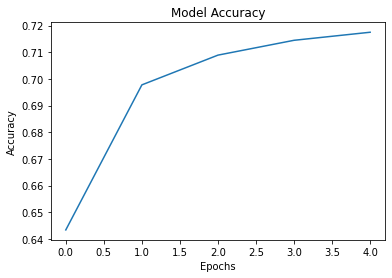

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

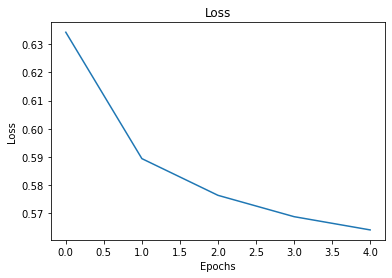

In [21]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

#2. PyTorch implementation

In [22]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
from torch.nn import functional as F

In [23]:
input_df_train = torch.Tensor(input_df_train)
input_df_test = torch.Tensor(input_df_test)

In [24]:
input_df_train = input_df_train.permute(0, 3, 1, 2)
input_df_test = input_df_test.permute(0, 3, 1, 2)

In [25]:
label_df_train = torch.tensor(label_df_train, dtype=torch.long)
label_df_test = torch.tensor(label_df_test, dtype=torch.long)

In [26]:
train_data = []
for i in range(len(input_df_train)):
    train_data.append([input_df_train[i], label_df_train[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)

In [27]:
test_data = []
for i in range(len(input_df_test)):
    test_data.append([input_df_test[i], label_df_test[i]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=64)

In [29]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 2, 32, 32])
torch.Size([64])


In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(2, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10800, 2)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [31]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10800, out_features=2, bias=True)
  )
)


In [32]:
num_epochs = 5
loss_list = []
for i in range(num_epochs):
    running_loss = 0
    for images, labels in train_loader:
        #Training
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward() #Backpropagation
        
        optimizer.step()
        running_loss += loss.item()
        loss_list.append(running_loss)
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/398400)) #dividing by the number of training samples

C:\ProgramData\Anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch 1 - Training loss: 0.010444116997551248
Epoch 2 - Training loss: 0.009794146230062806
Epoch 3 - Training loss: 0.009678813351101306
Epoch 4 - Training loss: 0.009642737553002365
Epoch 5 - Training loss: 0.009620934797144199


Thank you for the assignment. I thoroughly enjoyed it.